## Mandelbrotset using Numba and Cuda
-----
Inspiration and Guide: https://www.kaggle.com/code/landlord/numba-cuda-mandelbrot/notebook.
Current values from my Windows 11 machine with a Ryzen 7 3700X, 32 Gb RAM, and an RTX 2080 Super.

In [1]:
## Imports
import numpy as np
import numba as nb
from numba import cuda
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from typing import Callable
from datetime import datetime

## Setup
max_its = 256
x_min, x_max, y_min, y_max = -2.0, 1.0, -1.1, 1.1
width, height = 3200, 2400

run_loops = True
run_jit = True
run_cuda_jit = True

#### Baseline
-----

In [2]:
def almond(x0: float, y0: float, max_its: int=max_its) -> int:
    x_sq = 0
    y_sq = 0
    x = 0
    y = 0
    it = 0
    for it in range(max_its):
        y = (x + x) * y + y0
        x = x_sq - y_sq + x0
        x_sq = x * x
        y_sq = y * y
        if x_sq + y_sq >= 4:
            return it
    return max_its

In [3]:
## To reuse the "create_pixels" function also in the jit and cuda compiled 
#   variants I set up this class to easily bind the "correct" version of
#   the point-algorithm to it, without having to redefine the whole block.

class Pixeler:
    def __init__(self, point_algo: Callable):

        def create_pixels(
            x_min: float, 
            x_max: float, 
            y_min: float, 
            y_max: float, 
            pixels: np.ndarray, 
            max_its: int=max_its,
            ) -> None:

            height = pixels.shape[0]
            width  = pixels.shape[1]

            x_step = (x_max - x_min) / width
            y_step = (y_max - y_min) / height
                
            for i in range(height):
                y = y_min + i * y_step
                for k in range(width):
                    x = x_min + k * x_step
                    its = point_algo(x, y, max_its)
                    pixels[i, k] = its
                    
        self.sample = create_pixels

    def __call__(self, *args, **kwargs):
        return self.sample(*args, **kwargs)

Mandelbrot data created in 82.232996 s


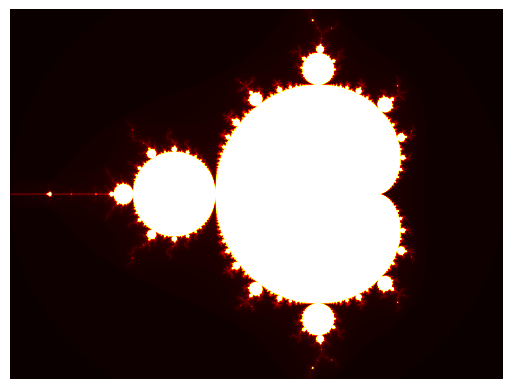

In [4]:
if run_loops:
    image = np.zeros((height, width), dtype = np.int16)
    pixeler = Pixeler(almond)
    start = timer()
    pixeler(-2.0, 1.0, -1.1, 1.1, image, max_its) 
    dt = timer() - start
    print("Mandelbrot data created in %f s" % dt)
    plt.imshow(image, cmap="hot")
    plt.axis('off')
    plt.show()

#### Numba Jit
-----

In [5]:
jit_mandel = nb.jit(nopython=True)(almond)
jit_create_pixels = nb.jit(nopython=True)(Pixeler(jit_mandel).sample)

Mandelbrot data created in 1.667329 s


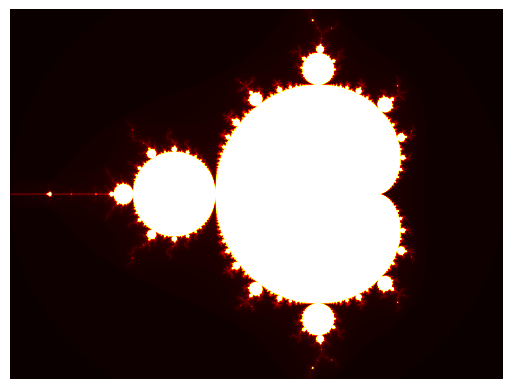

In [6]:
if run_jit:
    image = np.zeros((height, width), dtype=np.int16)
    start = timer()
    jit_create_pixels(x_min, x_max, y_min, y_max, image, max_its) 
    dt = timer() - start
    print("Mandelbrot data created in %f s" % dt)
    plt.imshow(image, cmap="hot")
    plt.axis('off')
    plt.show()

#### Numba Cuda
------

In [7]:
cuda_mandel = cuda.jit(nb.int16(nb.float32, nb.float32, nb.uint16), device=True)(almond)

@cuda.jit(nb.void(nb.float32, nb.float32, nb.float32, nb.float32, nb.int16[:,:], nb.int16))
def cuda_create_pixels(
    x_min: float, 
    x_max: float, 
    y_min: float, 
    y_max: float, 
    pixels: np.ndarray, 
    max_its: int=max_its,
    ) -> None:

    height = pixels.shape[0]
    width  = pixels.shape[1]

    x_step = (x_max - x_min) / width
    y_step = (y_max - y_min) / height

    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x
    gridY = cuda.gridDim.y * cuda.blockDim.y
        
    for i in range(startY, height, gridY):
        y = y_min + i * y_step
        for k in range(startX, width, gridX):
            x = x_min + k * x_step
            its = cuda_mandel(x, y, max_its)
            pixels[i, k] = its

Mandelbrot data created in 0.004283 s


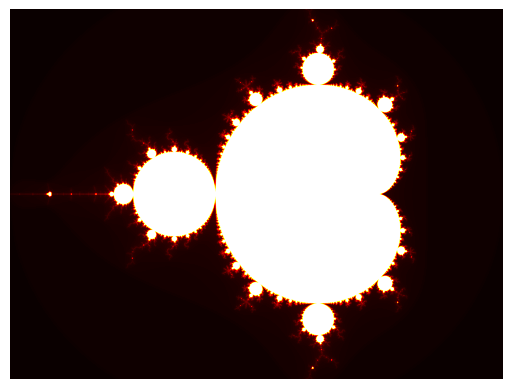

In [8]:
if run_cuda_jit:
    image = np.zeros((height, width), dtype = np.int16)
    blockdim = (32, 8)
    griddim = (32, 16)

    ## Maybe the conversion to the numpy array should be taken into account as well...
    start = timer()
    _image = cuda.to_device(image)
    cuda_create_pixels[griddim, blockdim](x_min, x_max, y_min, y_max, _image, 256) 
    dt = timer() - start

    print("Mandelbrot data created in %f s" % dt)
    image = np.array(_image)
    plt.imshow(image, cmap="hot")
    plt.axis('off')
    plt.savefig(f"./img/{datetime.now().strftime('%d-%m-%Y_%H-%M-%S')}", bbox_inches="tight", dpi=1000)
    plt.show()